In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk
from sklearn.model_selection import train_test_split
import seaborn as sns

from sklearn.preprocessing import StandardScaler, FunctionTransformer, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline

In [2]:
train_df = pd.read_csv('../training.csv') # split for test and train set is ready
test = pd.read_csv('../test.csv')

# Load preprocessed data

In [50]:
y_train = pd.read_csv("../preprocessed_data/y_train.csv")
y_whole = pd.read_csv("../preprocessed_data/y_whole.csv")
y_val  = pd.read_csv("../preprocessed_data/y_val.csv")

In [4]:
X_train = pd.read_csv("../preprocessed_data/X_train.csv")
X_whole = pd.read_csv("../preprocessed_data/X_whole.csv")
X_val  = pd.read_csv("../preprocessed_data/X_val.csv")

In [5]:
X_test  = pd.read_csv("../preprocessed_data/X_test.csv")

# Random Forest Classifier

W niniejszym pliku będziemy trenować model lasu losowego 

## base model

In [11]:
from sklearn.ensemble import RandomForestClassifier    
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn import metrics

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [7]:
rf_base = RandomForestClassifier(n_jobs=-1, n_estimators=100, max_depth=10, random_state=42)
rf_base.fit(X_train, y_train)

C:\Users\tymot\AppData\Local\Temp\ipykernel_20272\3000225647.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_base.fit(X_train, y_train)


RandomForestClassifier(max_depth=10, n_jobs=-1, random_state=42)

In [23]:
y_pred = rf_base.predict(X_val)

In [10]:
print(classification_report(y_pred, y_val))

              precision    recall  f1-score   support

           0       1.00      0.90      0.94     21248
           1       0.21      0.86      0.33       647

    accuracy                           0.90     21895
   macro avg       0.60      0.88      0.64     21895
weighted avg       0.97      0.90      0.93     21895



In [11]:
confusion_matrix(y_val, y_pred)

array([[19109,    93],
       [ 2139,   554]], dtype=int64)

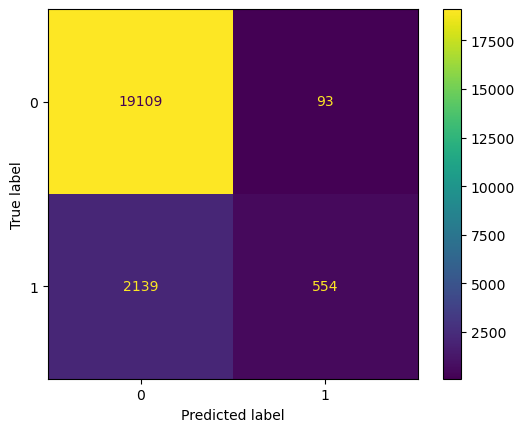

In [27]:
cm = confusion_matrix(y_val, y_pred, labels=rf_base.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=rf_base.classes_)
disp.plot()

In [28]:
from sklearn import metrics
import shap

def gini_roc(y_test, y_pred_proba, tytul):
    
    fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
    
    plt.plot(fpr,tpr)
    plt.title(tytul)
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    
    roc_auc = metrics.auc(fpr, tpr)
    gini = (2 * roc_auc) - 1

    return gini

def gini_train_val(model, X_train, y_train, X_val, y_val):
    
    y_pred_proba = model.predict_proba(X_train)[::,1]
    gini_train = gini_roc(y_train, y_pred_proba, "ROC Curve for Training Sample")
    print("gini_train: %.4f" % gini_train)
    
    y_pred_proba = model.predict_proba(X_val)[::,1]
    gini_val = gini_roc(y_val, y_pred_proba, "Roc Curve for Validation Sample")
    print("gini_val: %.4f" % gini_val)

    return

def shapley(model, X_train, X_val):
        
    # explain the model's predictions using SHAP
    # (same syntax works for LightGBM, CatBoost, scikit-learn, transformers, Spark, etc.)
    # model = lr
   
    explainer = shap.Explainer(model, X_train)
    
    shap_values = explainer(X_train)
    shap.summary_plot(shap_values, X_train)
    # visualize the first prediction's explanation
    shap.plots.waterfall(shap_values[0])

    # freature importance    
    shap.summary_plot(shap_values, X_train, plot_type="bar")
    
    shap.plots.bar(shap_values)
    shap.summary_plot(shap_values, plot_type='violin')
    shap.plots.bar(shap_values[0])
    shap.plots.waterfall(shap_values[0])
    shap.plots.force(shap_values[0])
    
    
    shap.plots.force(shap_values[1])
    
    shap.plots.heatmap(shap_values)
    
    # fig = shap.force_plot(explainer.expected_value, shap_values.values, X_train, feature_names = X_train.columns)
    # fig.savefig('testplot.png')
    # fig.plot()
    
    # fig = shap.force_plot(shap_values, X_train)
    # fig.plot()
   
    shap_values = explainer(X_val)
    shap.plots.beeswarm(shap_values)
    # visualize the first prediction's explanation
    shap.plots.waterfall(shap_values[0])
    
    # freature importance
    shap.summary_plot(shap_values, X_val, plot_type="bar")    
    
    

In [16]:
def roc_multiple_models(model_list, title):
    legend = []
    for item in model_list:
        model, X, y_real, legend_title = item
        legend.append(legend_title)

        y_pred_proba = model.predict_proba(X)[::,1]
        fpr, tpr, _ = metrics.roc_curve(y_real,  y_pred_proba)
        
        plt.plot(fpr,tpr)
        
        roc_auc = metrics.auc(fpr, tpr)
        print(f"AUC ROC score for {legend_title} equals {roc_auc}")

    plt.title(title)
    
    plt.ylabel('Sensivity')
    plt.xlabel('1 - Specifity')
    plt.legend(legend)
    plt.show()

AUC ROC score for train sample equals 0.8271831773068218
AUC ROC score for validation sample equals 0.7540045360828262


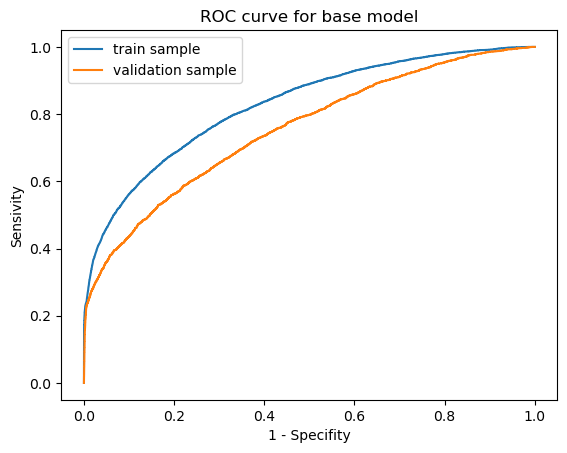

In [17]:
roc_multiple_models([(rf_base, X_train, y_train, "train sample"), (rf_base, X_val, y_val, "validation sample")], "ROC curve for base model")

## Parameter Tuning

using grid and random search, as well as self-implemented methods, we try to find the best parameters for our model

In [18]:
import pickle

In [ ]:
k_values = [i for i in range (5,31,2)]
scores = []

for k in k_values:
    rf = RandomForestClassifier(max_depth=k)
    score = cross_val_score(rf, X_whole, y, cv=5)
    scores.append(np.mean(score))
    print(f"{k} job done")

KeyboardInterrupt: 

Text(0, 0.5, 'Accuracy Score')

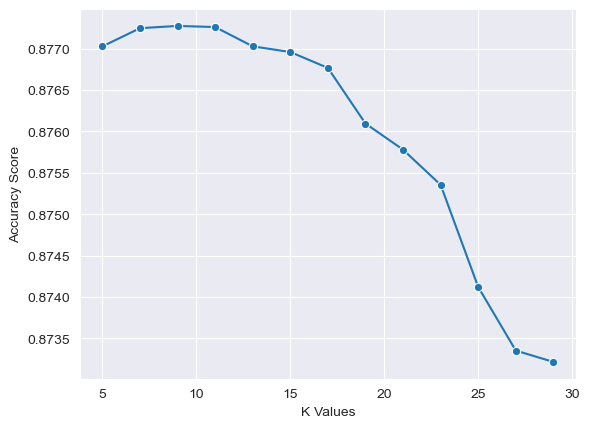

In [45]:
sns.lineplot(x = k_values, y = scores, marker = 'o')
plt.xlabel("Max tree depth")
plt.ylabel("Accuracy Score")

In [30]:
grid_params = {'bootstrap': [True, False],
 'max_depth': [5, 8, 10, 12, 15, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
 'max_features': ['log2', 'sqrt', None],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'criterion' : ['gini','entropy', 'log_loss'],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}

In [31]:
rf_random = RandomizedSearchCV(estimator = RandomForestClassifier(), param_distributions = grid_params, n_iter = 50, cv = 2, verbose=3, random_state=42, n_jobs = -1)

In [38]:
gs = GridSearchCV(RandomForestClassifier(), grid_params, verbose = 3, cv=3, n_jobs = -1, scoring = ('balanced_accuracy'))

In [32]:
rf_random.fit(X_train, y)

Fitting 2 folds for each of 50 candidates, totalling 100 fits


RandomizedSearchCV(cv=2, estimator=RandomForestClassifier(), n_iter=50,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'criterion': ['gini', 'entropy',
                                                      'log_loss'],
                                        'max_depth': [5, 8, 10, 12, 15, 20, 30,
                                                      40, 50, 60, 70, 80, 90,
                                                      100, None],
                                        'max_features': ['log2', 'sqrt', None],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=3)

In [33]:
rf_random.best_params_ # tutaj bedzie robil po accuracy - czy to git ? zobaczymy

{'n_estimators': 600,
 'min_samples_split': 5,
 'min_samples_leaf': 2,
 'max_features': None,
 'max_depth': 5,
 'criterion': 'log_loss',
 'bootstrap': True}

{'n_estimators': 1000,
 'min_samples_split': 5,
 'min_samples_leaf': 4,
 'max_features': 'sqrt',
 'max_depth': 90,
 'criterion': 'log_loss',
 'bootstrap': False}

In [34]:
filename = "saved_models/rf_random_2.sav"
pickle.dump(rf_random.best_estimator_, open(filename, 'wb'))


{'criterion': 'entropy', 'max_depth': 5, 'max_features': None}

those are the results - now training with those params

In [64]:
rf = RandomForestClassifier(n_jobs=-1, criterion= 'entropy', max_depth= 5, max_features= None, n_estimators=1000, random_state=42)
rf.fit(X_train, y_train)

C:\Users\tymot\AppData\Local\Temp\ipykernel_20272\1228066973.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X_train, y_train)


RandomForestClassifier(criterion='entropy', max_depth=5, max_features=None,
                       n_estimators=1000, n_jobs=-1, random_state=42)

In [22]:
y_pred = rf.predict(X_val)

In [16]:
print(classification_report(y_pred, y_val)) # those results ain't anyhow better

              precision    recall  f1-score   support

           0       0.99      0.90      0.94     21193
           1       0.21      0.82      0.34       702

    accuracy                           0.90     21895
   macro avg       0.60      0.86      0.64     21895
weighted avg       0.97      0.90      0.92     21895



In [17]:
confusion_matrix(y_val, y_pred)

array([[19074,   128],
       [ 2119,   574]], dtype=int64)

### self-made parameter tuning

In [19]:
model=RandomForestClassifier(n_jobs=-1,n_estimators=12,max_depth=16,random_state=42)
model.fit(X_train,y_train)
print("Train_acc:",model.score(X_train,y_train)," | Val_acc:",model.score(X_val,y_val))

C:\Users\tymot\AppData\Local\Temp\ipykernel_20272\413341269.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train,y_train)


Train_acc: 0.9143243031631695  | Val_acc: 0.8993377483443709


In [47]:
def test_model(**params):
        model=RandomForestClassifier(n_jobs=-1,random_state=42,**params)
        model.fit(X_train,y_train)
        print(" | Train_acc: ",model.score(X_train,y_train)," | Val_acc: ",model.score(X_val, y_val) ) 
        return model.score(X_train,y_train),model.score(X_val, y_val)

In [ ]:
test_model(n_estimators=12)
test_model(n_estimators=100)

In [81]:
rf_another = RandomForestClassifier(n_jobs=-1,n_estimators=100,max_depth=16,random_state=42)
rf_another.fit(X_whole,y_whole)
print(classification_report(rf_another.predict(X_val), y_val))

C:\Users\tymot\AppData\Local\Temp\ipykernel_20272\3191748578.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_another.fit(X_whole,y_whole)


              precision    recall  f1-score   support

           0       1.00      0.91      0.95     21104
           1       0.29      0.97      0.44       791

    accuracy                           0.91     21895
   macro avg       0.64      0.94      0.70     21895
weighted avg       0.97      0.91      0.93     21895



A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


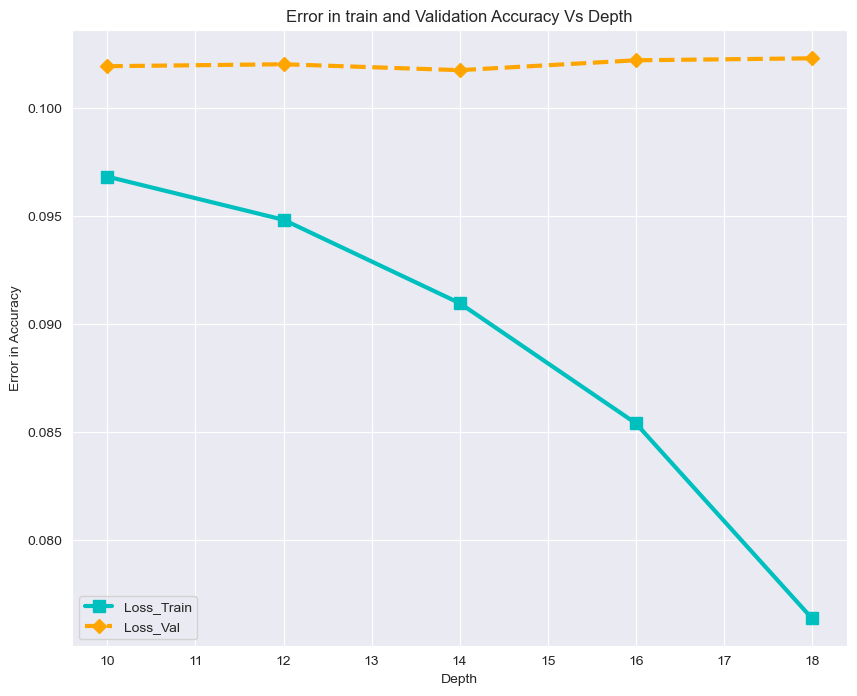

In [43]:
def max_depth(min,max):
    depth=[]
    tr_ac=[]
    va_ac=[]
    for i in range(min,max,2):
        model =RandomForestClassifier(max_depth=i, random_state=42)
        model.fit(X_train,y_train)
        depth.append(i)
        tr_ac.append(model.score(X_train,y_train))
        va_ac.append(model.score(X_val,y_val))
        
    tr_ac=1-np.array(tr_ac);
    va_ac=1-np.array(va_ac);
    
    plt.figure(figsize=(10,8))
    sns.set_style('darkgrid')
    plt.title('Error in train and Validation Accuracy Vs Depth')
    plt.xlabel('Depth')
    plt.ylabel('Error in Accuracy')
    plt.plot(depth,tr_ac,'cs-',linewidth=3,markersize=9)
    plt.plot(depth,va_ac,'D--',color='orange',linewidth=3, markersize=7)
    plt.legend(['Loss_Train','Loss_Val']);
    plt.show()
max_depth(10,20)

## feature importance
our model should be explainable - here we check feature importance using random forest base function `feature_importance_` as well as shapely library

In [77]:
importance_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': rf_another.feature_importances_
}).sort_values('importance', ascending=False)
importance_df.head(10)

,feature,importance
14,WheelType_OTHER,0.203870
4,MMRAcquisitionAuctionAveragePrice,0.076552
1,VehBCost,0.076462
5,MMRCurrentAuctionAveragePrice,0.072261
0,VehOdo,0.069984
2,WarrantyCost,0.049963
12,WheelType_Alloy,0.047782
3,VehicleAge,0.044100
6,ColorDanger,0.037920
13,WheelType_Covers,0.028473


<Axes: title={'center': 'Feature Importance'}, xlabel='importance', ylabel='feature'>

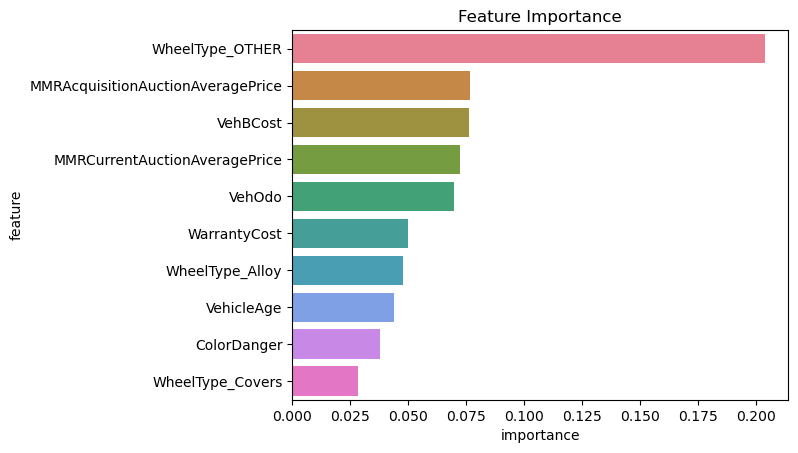

In [78]:

plt.title('Feature Importance')
sns.barplot(data=importance_df.head(10),palette='husl',x='importance', y='feature')

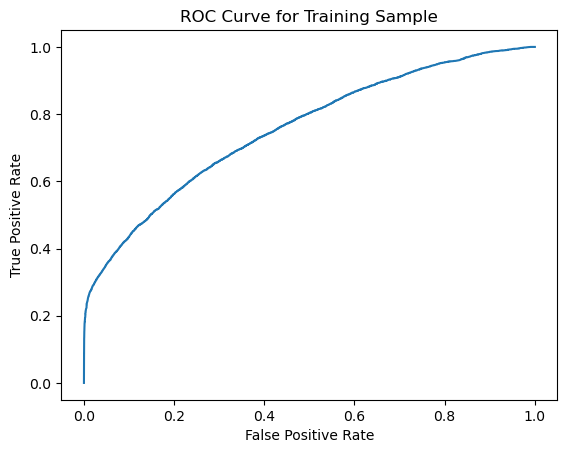

gini_train: 0.5099


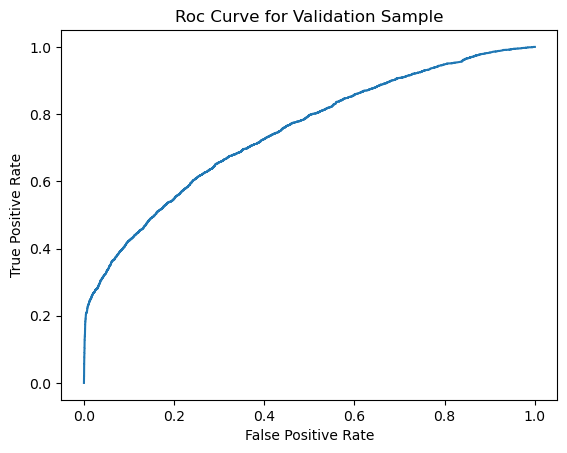

gini_val: 0.4929


In [21]:
gini_train_val(rf, X_train, y_train, X_val, y_val)

no tak srednio bym powiedzial

100%|===================| 102138/102176 [56:01<00:01]       

TypeError: only integer scalar arrays can be converted to a scalar index

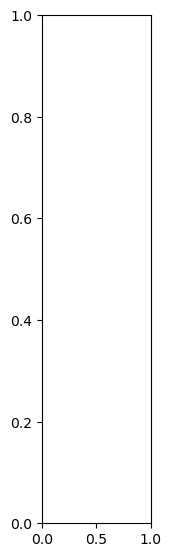

In [32]:
shapley(rf, X_train, X_val)

## sampling
our dataset is very unbalanced. therefore we will try to find a remedy to this problem with sampling techniques

### upsampling

In [55]:
from imblearn.over_sampling import SMOTE

oversample = SMOTE()

X_smote, y_smote = oversample.fit_resample(X_train, y_train)
X_smote.shape

(89590, 105)

In [56]:
rf_smote = RandomForestClassifier(n_jobs=-1)
rf_smote.fit(X_smote, y_smote)
y_smote_pred = rf_smote.predict(X_val)
print(classification_report(y_smote_pred, y_val))

C:\Users\tymot\AppData\Local\Temp\ipykernel_20272\1070324720.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_smote.fit(X_smote, y_smote)


              precision    recall  f1-score   support

           0       0.98      0.91      0.94     20708
           1       0.28      0.63      0.39      1187

    accuracy                           0.89     21895
   macro avg       0.63      0.77      0.66     21895
weighted avg       0.94      0.89      0.91     21895



### downsampling

In [43]:
from sklearn.utils import resample
Xy_train = X_train.join(y_train)
bad_buys = Xy_train[Xy_train["IsBadBuy"] == 1]
good_buys = Xy_train[Xy_train["IsBadBuy"] == 0]

good_buys = resample(good_buys,
             replace=True,
             n_samples=len(bad_buys),
             random_state=42)

X_down = pd.concat([bad_buys, good_buys])

y_down = X_down["IsBadBuy"]
del X_down["IsBadBuy"]

<Axes: >

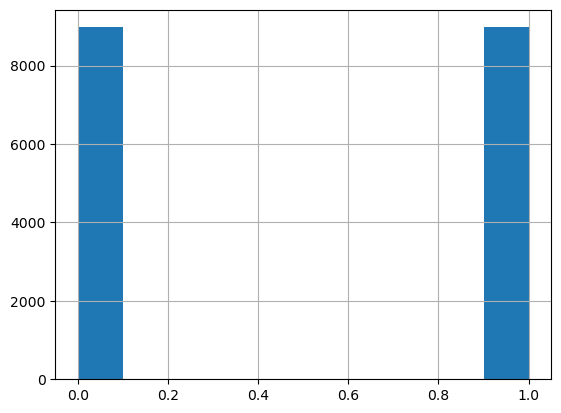

In [38]:
y_down.hist()

In [47]:
rf_down = RandomForestClassifier(n_jobs=-1)
rf_down.fit(X_down, y_down)
y_down_pred = rf_down.predict(X_val)
print(classification_report(y_down_pred, y_val))

              precision    recall  f1-score   support

           0       0.70      0.94      0.80     14334
           1       0.66      0.23      0.34      7561

    accuracy                           0.69     21895
   macro avg       0.68      0.58      0.57     21895
weighted avg       0.68      0.69      0.64     21895



AUC ROC score for without sampling equals 0.7456254822410735
AUC ROC score for SMOTE equals 0.7407289529489466
AUC ROC score for downsampling equals 0.7487685028668487


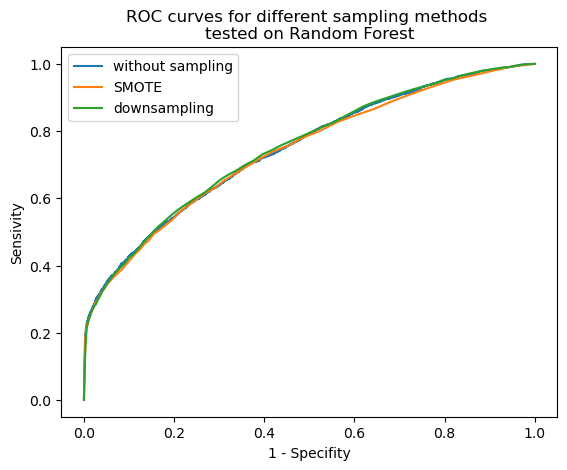

In [57]:
model_list = [(rf, X_val, y_val, "without sampling"), (rf_smote, X_val, y_val, "SMOTE"), (rf_down, X_val, y_val, "downsampling")]
roc_multiple_models(model_list, "ROC curves for different sampling methods \ntested on Random Forest")

## alternate cutoffs

In [75]:
threshold = 0.48

predicted_proba = rf_down.predict_proba(X_val)
y_pred = (predicted_proba [:,1] >= threshold).astype('int')

Text(0.5, 1.0, 'Confusion matrix for Random Forest \n0.48 threshold, downsampled')

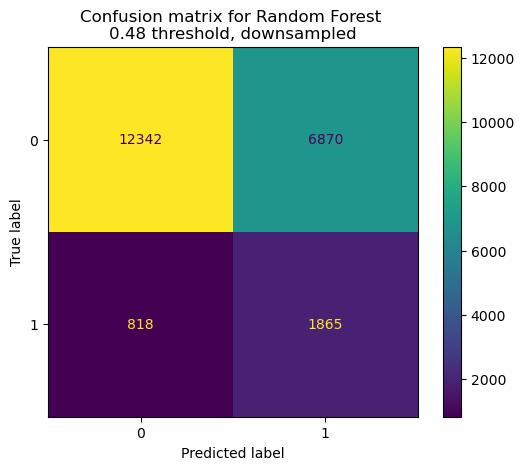

In [80]:
cm = confusion_matrix(y_val, y_pred, labels=rf_base.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=rf_base.classes_)
disp.plot()
plt.title(f"Confusion matrix for Random Forest \n{threshold} threshold, downsampled")

# Final outputs

In [45]:
X_test  = pd.read_csv("../preprocessed_data/X_test.csv")

In [82]:
y = rf_another.predict(X_test)
pd.DataFrame(y, columns=["IsBadBuy"]).join(test["RefId"]).to_csv("../out/another_out.csv", index=False)

In [53]:
y = rf_smote.predict(X_test)
pd.DataFrame(y, columns=["IsBadBuy"]).join(test["RefId"]).to_csv("../out/smote_out.csv", index=False)